# 机器学习 - 回归分析

本文使用燃料消耗数据集，进行单元及多元回归分析。使用 Intel oneAPI 进行加速计算。

## 加载所需库

本文使用 sklearn 进行回归分析，这里使用了 oneAPI 对 sklearn 进行了加速计算。

In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

from sklearnex import patch_sklearn
patch_sklearn()

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 下载数据集

```sh 
wget -O /resources/FuelConsumption.csv https://ibm.box.com/shared/static/ez95yurarnp0q31l9jl1ma51mh6qtxj2.csv
```


## 了解数据

### `FuelConsumptionCo2.csv`:
我们下载了一个燃料消耗的数据集，包括了特定车型的燃油消耗率，以及在加拿大零售销售的新轻型车辆的二氧化碳排放量。 [数据源](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** 年份 e.g. 2014
- **MAKE**  制造商 e.g. Acura
- **MODEL** 车型 e.g. ILX
- **VEHICLE CLASS** 车类 e.g. SUV
- **ENGINE SIZE** 发动机大小 e.g. 4.7
- **CYLINDERS** 汽缸 e.g 6
- **TRANSMISSION** 变速器 e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** 城市道路百公里油耗 e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** 告诉公路百公里油耗 e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** 综合路况百公里油耗 e.g. 9.2
- **CO2 EMISSIONS (g/km)**二氧化碳排放 e.g. 182  


### 读取数据

In [189]:
df = pd.read_csv("FuelConsumptionCo2.csv") 
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


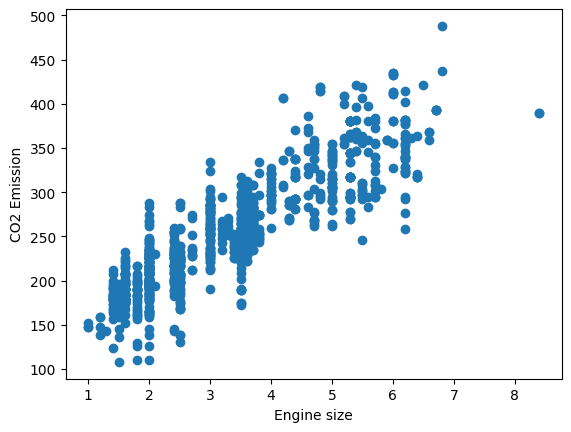

In [190]:
plt.scatter(df.ENGINESIZE, df.CO2EMISSIONS)
plt.xlabel("Engine size")
plt.ylabel("CO2 Emission")
plt.show()

## 前期准备

### 创建训练和测试数据集

随机选择 80% 的数据作为训练数据集，20% 的数据作为测试数据集。

In [191]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

### 查看训练数据的分布

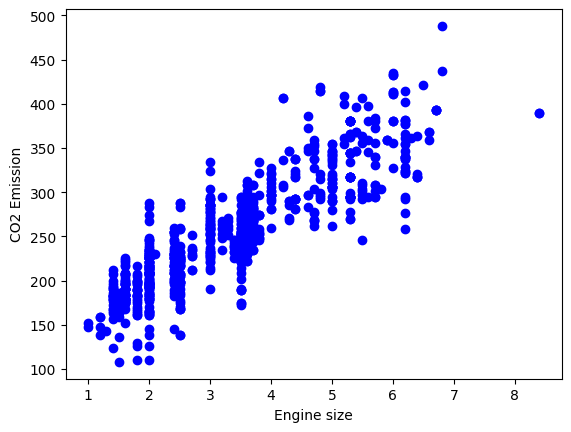

In [192]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS, color='blue')
plt.xlabel("Engine size")
plt.ylabel("CO2 Emission")
plt.show()

## 回归分析

### 线性回归

线性回归是一个线性模型，其系数为B = (B1, ..., Bn)，目的是最小化拟合曲线在每个x上的对应的预测y值与实际y之间的方差的和。

#### 线性回归模型


In [193]:
model = linear_model.LinearRegression()
train_x=train[['ENGINESIZE']].values
train_y=train[['CO2EMISSIONS']].values

model.fit(train_x, train_y)

print ('Coefficients: ', model.coef_)
print ('Intercept: ', model.intercept_)

Coefficients:  [[38.93822204]]
Intercept:  [125.31336482]


#### 绘制输出

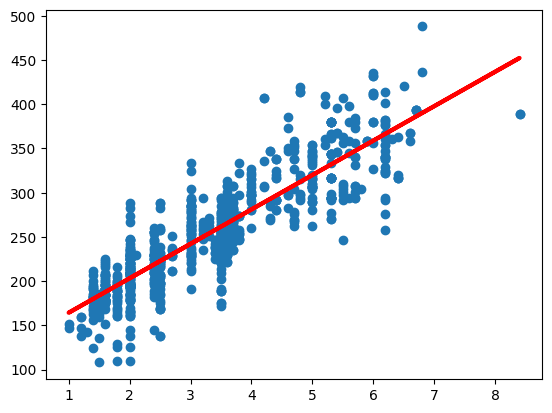

In [194]:
train_y_pred = model.predict(train_x)

plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS)
plt.plot(train_x, train_y_pred, linewidth=3, color='red')
plt.show()

### 评估

前面使用了训练数据进行了线性回归，接下来使用测试数据评估模型

Residual mean of squares: 947.26
Variance score: 0.74


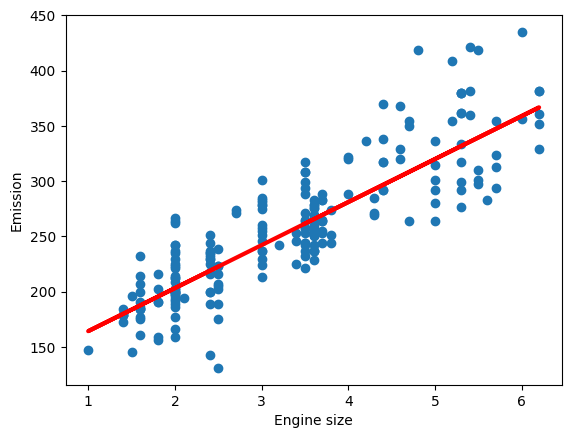

In [195]:
test_x=test[['ENGINESIZE']].values
test_y=test[['CO2EMISSIONS']].values
test_y_=model.predict(test_x)

print("Residual mean of squares: %.2f" % np.mean((test_y_ - test_y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(test_x, test_y))

# Plot outputs
plt.scatter(test_x, test_y)
plt.plot(test_x, test_y_, linewidth=3, color='red')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

### 非线性回归

多项式回归是线性回归的一个特例。主要取决于你如何选择你的特征变量。看看有两个变量的多元回归:x1和x2。线性回归看起来是这样的:y=a1 \* x1 + a2 \* x2。

假设现在你想执行一个多项式回归（让我们创建一个2阶多项式），我们将添加一些额外的特征：x1\*x2, x1^2 和 x2^2，那么你的线性回归应该是：
y = a1 \* x1 + a2 \* x2 + a3 \* x1 \*x2 + a4 \* x1^2 + a5 \* x2^2

In [196]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

train_x=np.asanyarray(train[['ENGINESIZE']])
train_y=np.asanyarray(train[['CO2EMISSIONS']])

poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)

In [197]:
model = linear_model.LinearRegression()
model.fit(train_x_poly, train_y)

LinearRegression()

In [198]:
# sort test x for plotting
test_x, test_y = zip(*sorted(zip(test_x, test_y)))

test_x_poly = poly.fit_transform(test_x)
train_y_pred = model.predict(test_x_poly)

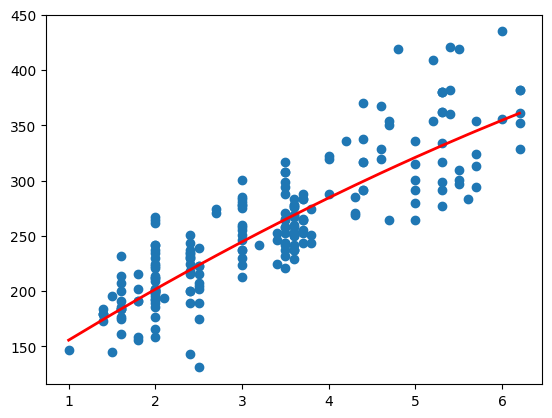

In [199]:
plt.scatter(test_x, test_y)
plt.plot(test_x, train_y_pred, linewidth=2, color='red')

plt.show()

### 多元回归模型

多元回归模型可以有多个输出，这里我们展示一个线性多元回归模型。

In [200]:
from sklearn import linear_model

model = linear_model.LinearRegression()

train_x = train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']].values
train_y = train[['CO2EMISSIONS']].values

model.fit(train_x, train_y)

print('Coefficients: ', model.coef_)
print ('Intercept: ', model.intercept_)

Coefficients:  [[10.77959658  7.29755883  9.76816294]]
Intercept:  [64.45139171]


In [201]:
test_x = test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']].values
test_y = test[['CO2EMISSIONS']].values

train_y_pred = model.predict(test_x)

print("Residual sum of squares: %.2f" % np.mean((train_y_pred - test_y) ** 2))
print('Variance score: %.2f' % model.score(train_x, train_y))

Residual sum of squares: 538.96
Variance score: 0.87
